In [25]:
import numpy as np 
import pandas as pd 
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [26]:
# runtime check (GPU + CUDA)
!nvidia-smi -L || true
!nvidia-smi || true
!nvcc --version || true

import sys, os, subprocess, json
cuda_available = False
try:
    import torch
    cuda_available = torch.cuda.is_available()
except Exception:
    pass

print("Python:", sys.version.split()[0])
print("Torch available:", 'yes' if 'torch' in sys.modules else 'no', "cuda_available:", cuda_available)


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-492d7175-45bb-2af2-c28c-950e8f997009)
Mon Nov 17 06:43:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             36W /  250W |    4977MiB /  16384MiB |      0%      Default |
|                                         |                    

In [27]:
import random
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [28]:
train=pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")

In [29]:
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [30]:
coords=pd.DataFrame(list(train.bbox.apply(lambda x:x[1:-1].split(",")).values),columns=["x1","y1","w","h"])

In [31]:
df=pd.concat([train,coords],axis=1)

In [32]:
df["x1"]=pd.to_numeric(df["x1"])
df["y1"]=pd.to_numeric(df["y1"])
df["w"]=pd.to_numeric(df["w"])
df["h"]=pd.to_numeric(df["h"])

In [33]:
df["x2"]=df["x1"]+df["w"]
df["y2"]=df["y1"]+df["h"]

In [34]:
df.drop(["bbox","width","height","w","h","source"],axis=1,inplace=True)

In [35]:
df.head()

image_id     x1     y1     x2     y2
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

In [36]:
unique_imgs=df.image_id.unique()

In [37]:
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [38]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]

        # get xywh
        # Note: This line needs to be updated to correctly use x1, y1, x2, y2 from the dataframe
        b = self.df[self.df.image_id == image_name][["x1","y1","x2","y2"]].values.astype("float")

        # convert to xyxy (assuming b now contains [x1, y1, x2, y2])
        boxes = b # already in xyxy format after data prep
        
        # filter invalid boxes
        valid = (boxes[:,2] > boxes[:,0]) & (boxes[:,3] > boxes[:,1])
        boxes = boxes[valid]

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        # load image
        img = Image.open(f"/kaggle/input/global-wheat-detection/train/{image_name}.jpg").convert("RGB")
        
        # ==========================================================
        # 🎭 MASK R-CNN FIX: ADD DUMMY MASKS
        # The Mask R-CNN requires a mask for every box.
        # We create a placeholder mask tensor of shape [N, H, W] 
        # where N is the number of boxes, and H, W are image dimensions (1024x1024)
        # We fill them with ones (fully segmented region).
        # ==========================================================
        
        if boxes.shape[0] == 0:
            # Handle empty case (important for data loading stability)
            masks = torch.empty((0, img.height, img.width), dtype=torch.uint8)
        else:
            # Create N masks (one for each box), size HxW, filled with ones.
            masks = torch.ones((boxes.shape[0], img.height, img.width), dtype=torch.uint8)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": labels,
            "masks": masks  # <--- NEW REQUIRED KEY
        }

        img = T.ToTensor()(img)
        return img, target

In [39]:
train_inds , val_inds = train_test_split(range(unique_imgs.shape[0]) , test_size = 0.1)

In [40]:
def custom_collate(data):
    return data

In [41]:
train_dl = torch.utils.data.DataLoader(CustDat(df , unique_imgs , train_inds) ,
                                        batch_size = 2,
                                        shuffle = True ,
                                        collate_fn = custom_collate ,
                                        pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDat(df , unique_imgs , val_inds) ,
                                        batch_size = 2 ,
                                        shuffle = True ,
                                        collate_fn = custom_collate ,
                                        pin_memory = True if torch.cuda.is_available() else False)

In [42]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor 
import torch.nn as nn

def get_mask_rcnn_model(num_classes):
    """
    Loads a pre-trained Mask R-CNN and replaces the final layers 
    to accommodate a custom number of classes.
    """
    # Load an instance segmentation model pre-trained on COCO
    # We use 'MaskRCNN_ResNet50_FPN_Weights.DEFAULT' for the latest best weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    
    # --- 1. Replace the Box Predictor (for object detection) ---
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained box predictor with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # --- 2. Replace the Mask Predictor (for instance segmentation) ---
    
    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels
    
    # Replace the pre-trained mask predictor with a new one.
    # The MaskRCNNPredictor expects 3 arguments: in_channels, hidden_channels, num_classes
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    # Freeze the new layers if you only want to train the final heads
    # for a quick fine-tuning run (optional, depends on your goal)
    # for param in model.parameters():
    #     param.requires_grad = True

    return model

# Example usage (assuming num_classes is defined based on your dataset)
num_classes = 2 # e.g., 1 object class + 1 background class (always 0)
model = get_mask_rcnn_model(num_classes)

In [43]:
# ===== HYPERPARAMETERS TO TUNE =====

hyperparams = {
    "learning_rate": 0.0005,
    "weight_decay": 1e-4,
    "score_threshold": 0.35,
    "nms_threshold": 0.45,
    "batch_size": 2,          # set in DataLoader
    "num_epochs": 50,
}

# Apply thresholds to Faster-RCNN
model.roi_heads.score_thresh = hyperparams["score_threshold"]
model.roi_heads.nms_thresh   = hyperparams["nms_threshold"]

# Use AdamW (better for fine-tuning)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparams["learning_rate"],
    weight_decay=hyperparams["weight_decay"]
)

print("Using hyperparameters:", hyperparams)


Using hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.0001, 'score_threshold': 0.35, 'nms_threshold': 0.45, 'batch_size': 2, 'num_epochs': 50}


In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [45]:
device

device(type='cuda')

In [58]:
# --- EARLY STOPPING HYPERPARAMETERS ---
ES_PATIENCE = 8      # How many epochs to wait for improvement
ES_MIN_DELTA = 0.001 # Minimum change in loss to qualify as improvement
# ------------------------------------

# --- Setup Checkpoint Path and Variables ---
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
checkpoint_path = os.path.join(save_dir, "mask_rcnn_checkpoint.pth") 
best_model_path = os.path.join(save_dir, "best_mask_rcnn_weights.pth")

start_epoch = 0
loss_history = [] 
# Early Stopping variables
best_loss = float('inf') # Initialize with a very large number
patience_counter = 0     # Counter for epochs without improvement

# --- Resuming Logic ---
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Resuming training...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load the state dictionaries
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Restore training state and Early Stopping variables
    start_epoch = checkpoint['epoch']
    loss_history = checkpoint.get('loss_history', []) 
    best_loss = checkpoint.get('best_loss', float('inf'))
    patience_counter = checkpoint.get('patience_counter', 0)
    
    print(f"Resumed from epoch {start_epoch}. Total epochs to run: {hyperparams['num_epochs']}")
else:
    print("No checkpoint found. Starting training from scratch.")

model.train() # CRITICAL: Set model to training mode
model.to(device)

# ----------------------------------------------------
# --- 2. Training Loop with Checkpoint Saving and Early Stopping ---
# ----------------------------------------------------
for epoch in range(start_epoch, hyperparams["num_epochs"]):
    epoch_loss = 0
    torch.cuda.empty_cache()

    for batch in train_dl:
        imgs = [sample[0] for sample in batch]
        targets = [sample[1] for sample in batch]

        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{hyperparams['num_epochs']}, Loss = {epoch_loss:.4f}")

    # --- Early Stopping and Best Model Check ---
    if epoch_loss < best_loss - ES_MIN_DELTA:
        print(f"-> Loss improved from {best_loss:.4f} to {epoch_loss:.4f}. Patience reset.")
        best_loss = epoch_loss
        patience_counter = 0
        
        # Save the BEST model weights (for inference later)
        torch.save(model.state_dict(), best_model_path)
        print(f"-> Saved BEST model weights to {best_model_path}")

    else:
        patience_counter += 1
        print(f"-> Loss did not improve. Patience: {patience_counter}/{ES_PATIENCE}")

    # --- Check for Stop Condition ---
    if patience_counter >= ES_PATIENCE:
        print(f"################################################")
        print(f"# Early stopping triggered after {patience_counter} epochs without improvement! #")
        print(f"################################################")
        break

    # --- Checkpoint Saving Logic (Saves current state for resuming) ---
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history,
        # Save ES variables
        'best_loss': best_loss,
        'patience_counter': patience_counter,
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"-> Checkpoint saved to {checkpoint_path} at epoch {epoch + 1}")

Checkpoint found. Resuming training...
Resumed from epoch 19. Total epochs to run: 50
Epoch 20/50, Loss = 1094.0495
-> Loss did not improve. Patience: 8/8
################################################
# Early stopping triggered after 8 epochs without improvement! #
################################################


In [59]:
loss_history

[1501.5878730118275,
 1299.654797166586,
 1238.7114033848047,
 1198.1219701170921,
 1160.9346624910831,
 1137.4052087068558,
 1112.251332193613,
 1107.6973671615124,
 1072.4715081453323,
 1067.7209941446781,
 1061.6741768568754,
 1058.6529018878937,
 1090.8530571758747,
 1065.1151757240295,
 1061.6599479317665,
 2428.2857029139996,
 2193.587848186493,
 1442.4639754891396,
 1117.5114333629608,
 1094.0495223402977]

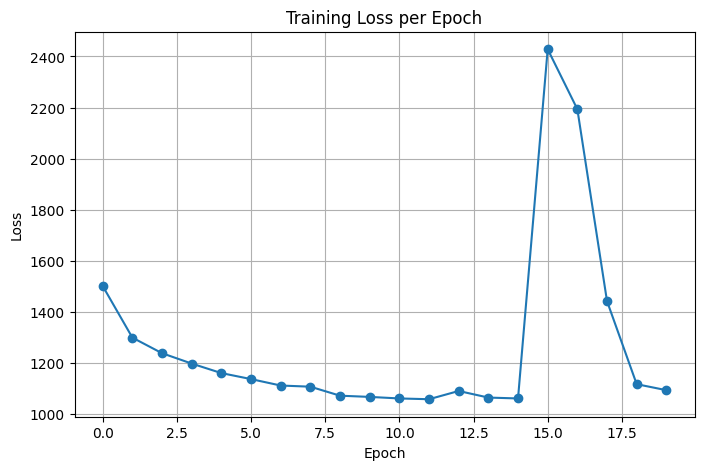

In [60]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [67]:
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter = max(0, xB - xA) * max(0, yB - yA)

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = area1 + area2 - inter + 1e-6
    return inter / union


In [ ]:
# model.eval()
# data = iter(val_dl).__next__()

In [68]:
def evaluate(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    tp = fp = fn = 0
    ious = []

    with torch.no_grad():
        for batch in dataloader:
            img = batch[0][0].to(device)
            tgt = batch[0][1]

            output = model([img])[0]

            pred_boxes = output["boxes"].cpu()
            pred_scores = output["scores"].cpu()
            gt_boxes = tgt["boxes"].cpu()

            keep = torchvision.ops.nms(pred_boxes, pred_scores, 0.45)
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]

            matched_gt = set()

            for i, pb in enumerate(pred_boxes):
                if pred_scores[i] < hyperparams["score_threshold"]:
                    continue
                max_iou = 0
                max_gt = -1

                for j, gb in enumerate(gt_boxes):
                    iou = compute_iou(pb, gb)
                    if iou > max_iou:
                        max_iou = iou
                        max_gt = j

                if max_iou >= iou_threshold:
                    tp += 1
                    matched_gt.add(max_gt)
                    ious.append(max_iou)
                else:
                    fp += 1

            fn += len(gt_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    mean_iou  = sum(ious)/len(ious)

    # simplified mAP@0.5
    map50 = precision * recall  # proxy for mAP-like behavior

    return {
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "IoU": mean_iou,
        "mAP@0.5": map50
    }


In [69]:
metrics = evaluate(model, val_dl, device)
metrics


{'Precision': 0.9013817392439201,
 'Recall': 0.9000405788042688,
 'F1': 0.9007101597771083,
 'IoU': tensor(0.7717),
 'mAP@0.5': 0.8112801423126963}

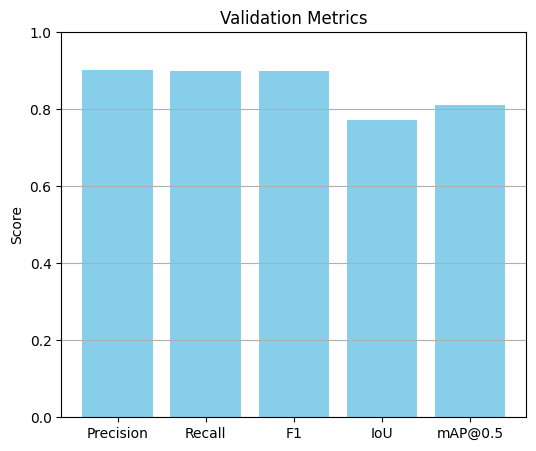

In [71]:
plt.figure(figsize=(6,5))
plt.bar(metrics.keys(), metrics.values(), color="skyblue")
plt.title("Validation Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()


In [83]:
from PIL import ImageDraw

In [73]:
model.eval()
batch = next(iter(val_dl))

img = batch[0][0].to(device)
gt_boxes = batch[0][1]['boxes']
gt_labels=batch[0][1]['labels']

output = model([img])[0]


In [74]:
output

{'boxes': tensor([[2.2562e+02, 6.0075e+02, 3.0714e+02, 6.7447e+02],
         [8.5962e+02, 5.6282e+02, 9.3285e+02, 6.3296e+02],
         [9.7329e+01, 7.8451e+00, 1.7761e+02, 6.3335e+01],
         [3.0562e+02, 0.0000e+00, 3.5418e+02, 7.0337e+01],
         [3.7059e+02, 8.4792e+02, 4.4134e+02, 8.9905e+02],
         [1.1165e+02, 8.2373e+01, 2.6477e+02, 2.4736e+02],
         [2.4719e+02, 3.4826e+02, 3.5124e+02, 4.2537e+02],
         [5.5362e+02, 3.6841e+02, 6.0571e+02, 4.4253e+02],
         [9.6437e+02, 4.7461e+02, 1.0218e+03, 5.5017e+02],
         [6.4703e+02, 7.0014e+02, 7.2950e+02, 7.8901e+02],
         [2.0747e+02, 7.3004e+02, 2.7531e+02, 8.0419e+02],
         [4.9873e+02, 3.5565e+02, 5.5575e+02, 4.3519e+02],
         [8.9237e+02, 4.3163e+02, 9.5624e+02, 5.2825e+02],
         [2.1766e+02, 4.1413e+01, 2.8540e+02, 8.7545e+01],
         [3.9998e+02, 3.5658e+02, 4.9409e+02, 4.7879e+02],
         [3.1754e+02, 5.7145e+02, 4.3712e+02, 6.4818e+02],
         [5.7359e+01, 7.3058e+00, 1.2915e+02, 6

In [76]:
pred_boxes = output["boxes"].cpu()
pred_scores = output["scores"].cpu()

keep = torchvision.ops.nms(pred_boxes, pred_scores, hyperparams["nms_threshold"])
pred_boxes = pred_boxes[keep]
pred_scores = pred_scores[keep]

In [77]:
pred_boxes.shape, keep.shape

(torch.Size([65, 4]), torch.Size([65]))

# # Convert image

In [78]:

img_np = (img.permute(1,2,0).cpu().numpy() * 255).astype("uint8")

In [79]:
img_np

array([[[ 27,  33,  29],
        [ 24,  30,  26],
        [ 21,  27,  23],
        ...,
        [ 26,  37,  20],
        [ 13,  25,   5],
        [ 16,  28,   8]],

       [[ 30,  36,  32],
        [ 26,  32,  28],
        [ 22,  28,  24],
        ...,
        [ 55,  66,  49],
        [ 31,  43,  23],
        [ 22,  34,  14]],

       [[ 35,  41,  37],
        [ 30,  36,  32],
        [ 23,  29,  25],
        ...,
        [ 91, 102,  85],
        [ 60,  71,  54],
        [ 37,  48,  31]],

       ...,

       [[ 29,  39,  40],
        [ 29,  39,  40],
        [ 29,  39,  40],
        ...,
        [ 24,  25,  17],
        [ 25,  26,  18],
        [ 26,  27,  19]],

       [[ 29,  39,  38],
        [ 29,  39,  38],
        [ 29,  39,  38],
        ...,
        [ 25,  26,  20],
        [ 23,  24,  18],
        [ 23,  24,  18]],

       [[ 29,  39,  38],
        [ 29,  39,  38],
        [ 28,  38,  37],
        ...,
        [ 27,  28,  23],
        [ 25,  26,  20],
        [ 23,  24,  18]]

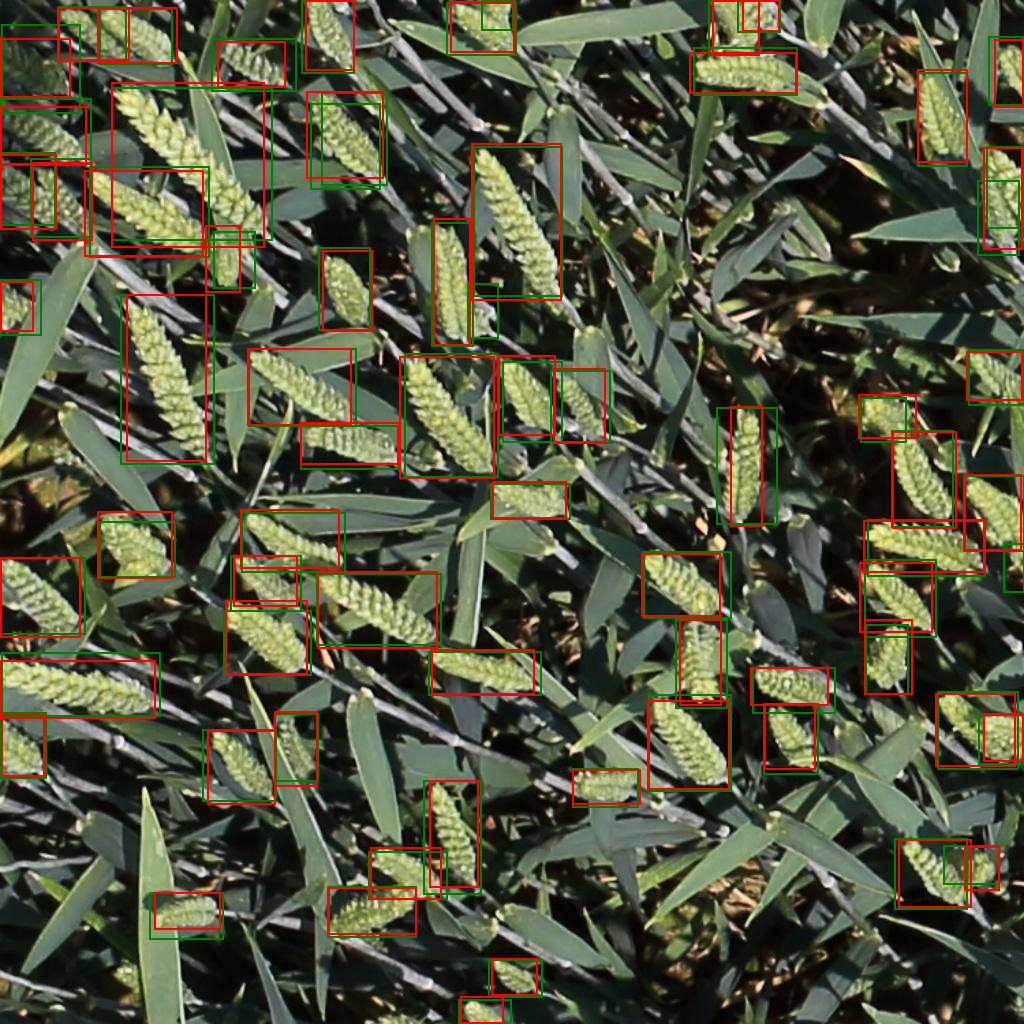

In [84]:
vis = Image.fromarray(img_np)
draw = ImageDraw.Draw(vis)

# Green = Ground Truth
for g in gt_boxes:
    draw.rectangle(list(g.detach().cpu().numpy()), outline="green", width=2)

# Red = Predictions
for p in pred_boxes:
    draw.rectangle(list(p.detach().cpu().numpy()), outline="red", width=2)

vis

# ---- Random sample from validation set ----

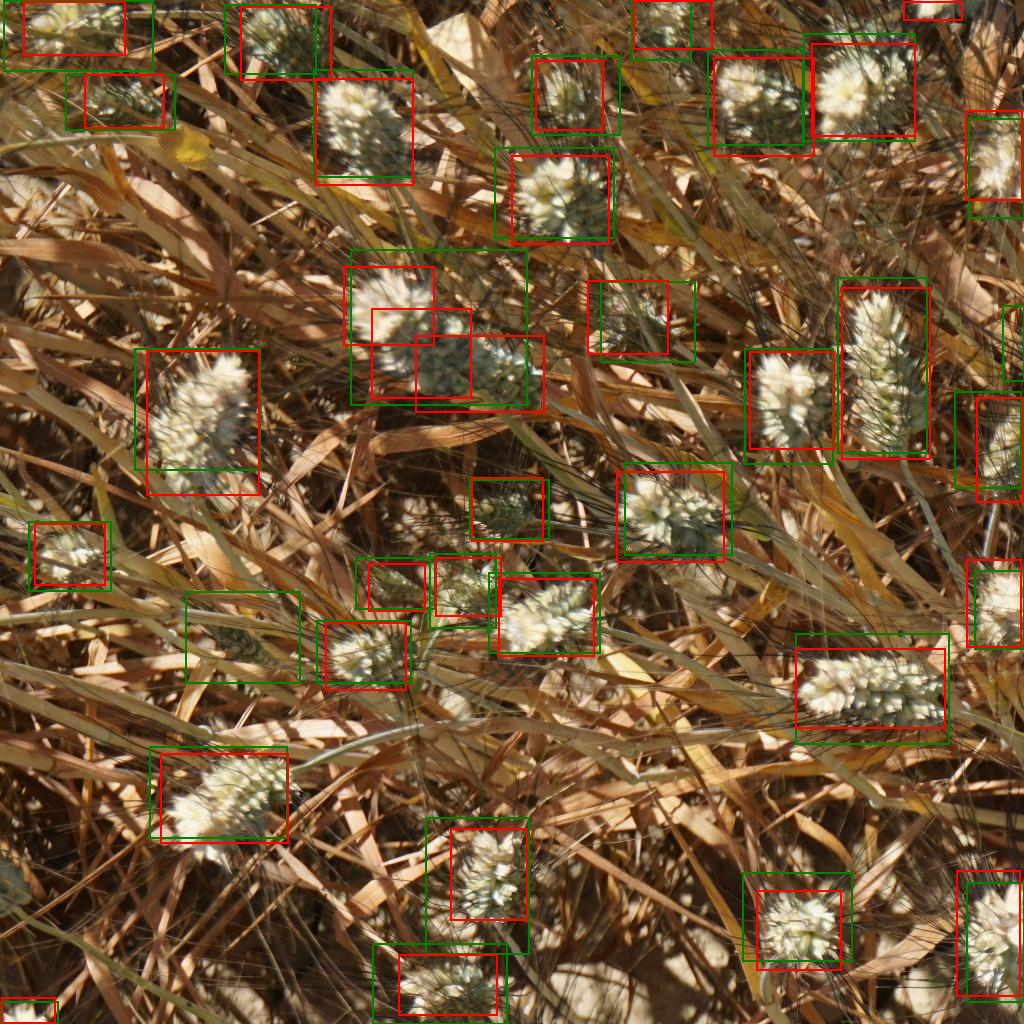

In [85]:
import random
from PIL import ImageDraw

# ---- Random sample from validation set ----
idx = random.choice(val_inds)                     # pick random index
dataset = CustDat(df, unique_imgs, val_inds)      # reuse existing dataset
img, target = dataset[val_inds.index(idx)]        # load the sample

gt_boxes = target["boxes"]
img_tensor = img.to(device)

# ---- Run model ----
model.eval()
with torch.no_grad():
    output = model([img_tensor])[0]

pred_boxes = output["boxes"].cpu()
pred_scores = output["scores"].cpu()

# ---- Apply NMS ----
keep = torchvision.ops.nms(pred_boxes, pred_scores, hyperparams["nms_threshold"])
pred_boxes = pred_boxes[keep]
pred_scores = pred_scores[keep]

# ---- Convert to image ----
img_np = (img.permute(1, 2, 0).numpy() * 255).astype("uint8")
vis = Image.fromarray(img_np)
draw = ImageDraw.Draw(vis)

# ---- Draw GT (green) ----
for g in gt_boxes:
    draw.rectangle(list(g.numpy()), outline="green", width=2)

# ---- Draw Predictions (red) ----
for p in pred_boxes:
    draw.rectangle(list(p.numpy()), outline="red", width=2)

# ---- Show image ----
vis


In [86]:
import os

# Create save folder
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Determine save name based on epochs
if hyperparams["num_epochs"] == 10:
    save_name = "faster_rcnn_c1.pth"
elif hyperparams["num_epochs"] == 15:
    save_name = "faster_rcnn_c2.pth"
elif hyperparams["num_epochs"] == 20:
    save_name = "faster_rcnn_c3.pth"
else:
    # fallback for other epochs
    save_name = f"faster_rcnn_epochs_{hyperparams['num_epochs']}.pth"

save_path = os.path.join(save_dir, save_name)

# Save weights
torch.save(model.state_dict(), save_path)

print(f"Model saved as: {save_path}")


Model saved as: saved_models/faster_rcnn_epochs_50.pth


In [88]:
ls saved_models

best_mask_rcnn_weights.pth  faster_rcnn_epochs_50.pth  mask_rcnn_checkpoint.pth
